# Player Vector for Messi

In [291]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [292]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import NMF

#### Load Shots

In [293]:
df_shots = pd.read_csv('Shots.csv', delimiter=';')
df_shots.head()

,minute,second,team,x,y,outcome
0,21,42,Barcelona,50.88,85.20,Saved
1,29,33,Barcelona,34.96,91.68,Missed
2,35,3,Barcelona,44.40,101.64,Saved
3,41,3,Barcelona,27.92,96.36,Saved
4,42,9,Barcelona,50.40,104.88,Saved


In [294]:
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   minute   20 non-null     int64  
 1   second   20 non-null     int64  
 2   team     20 non-null     object 
 3   x        20 non-null     float64
 4   y        20 non-null     float64
 5   outcome  20 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.1+ KB


In [295]:
df_shots.describe()

,minute,second,x,y
count,20.000000,20.000000,20.000000,20.000000
mean,59.250000,26.100000,41.276000,98.226000
std,20.606271,19.726819,9.641995,7.137144
min,21.000000,3.000000,21.600000,85.200000
25%,42.000000,9.000000,34.660000,91.620000
50%,62.000000,22.000000,43.240000,98.280000
75%,77.750000,44.250000,49.080000,104.250000
max,89.000000,58.000000,54.560000,108.000000


#### Load passes

In [296]:
df_passes = pd.read_csv('Passes.csv', delimiter=';')
df_passes.head()

,player,minute,second,x,y,type,outcome,endX,endY
0,messi,45,0,50,50,Pass,Successful,40,43
1,messi,45,25,63,48,Pass,Successful,75,83
2,messi,46,4,74,58,Pass,Successful,71,65
3,messi,46,7,76,68,Pass,Successful,95,78
4,messi,46,55,100,1,Pass,Unsuccessful,96,38


In [297]:
df_passes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   player   49 non-null     object
 1   minute   49 non-null     int64 
 2   second   49 non-null     int64 
 3   x        49 non-null     int64 
 4   y        49 non-null     int64 
 5   type     49 non-null     object
 6   outcome  49 non-null     object
 7   endX     49 non-null     int64 
 8   endY     49 non-null     int64 
dtypes: int64(6), object(3)
memory usage: 3.6+ KB


In [298]:
df_passes.describe()

,minute,second,x,y,endX,endY
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,67.836735,26.775510,70.755102,41.346939,72.163265,48.673469
std,14.399576,15.551347,15.690404,26.666576,17.279982,26.084309
min,45.000000,0.000000,30.000000,1.000000,22.000000,4.000000
25%,56.000000,17.000000,64.000000,25.000000,63.000000,26.000000
50%,68.000000,25.000000,71.000000,42.000000,71.000000,52.000000
75%,79.000000,40.000000,79.000000,58.000000,87.000000,69.000000
max,94.000000,59.000000,100.000000,100.000000,98.000000,96.000000


## Building Player Vector

In [299]:
# Extract x, y coordinates from dataframe
x_shot, y_shot = df_shots['x'], df_shots['y']
x_pass, y_pass = df_passes['x'], df_passes['y']

# Parameters for heatmap
N, M = 50, 50
sigma = 5.0
k = 3

### 1. Calculating Heatmaps
#### 1.1 Counting

In [300]:
X_shot, _, _ = np.histogram2d(x_shot, y_shot, bins=[N, M])
X_pass, _, _ = np.histogram2d(x_pass, y_pass, bins=[N, M])

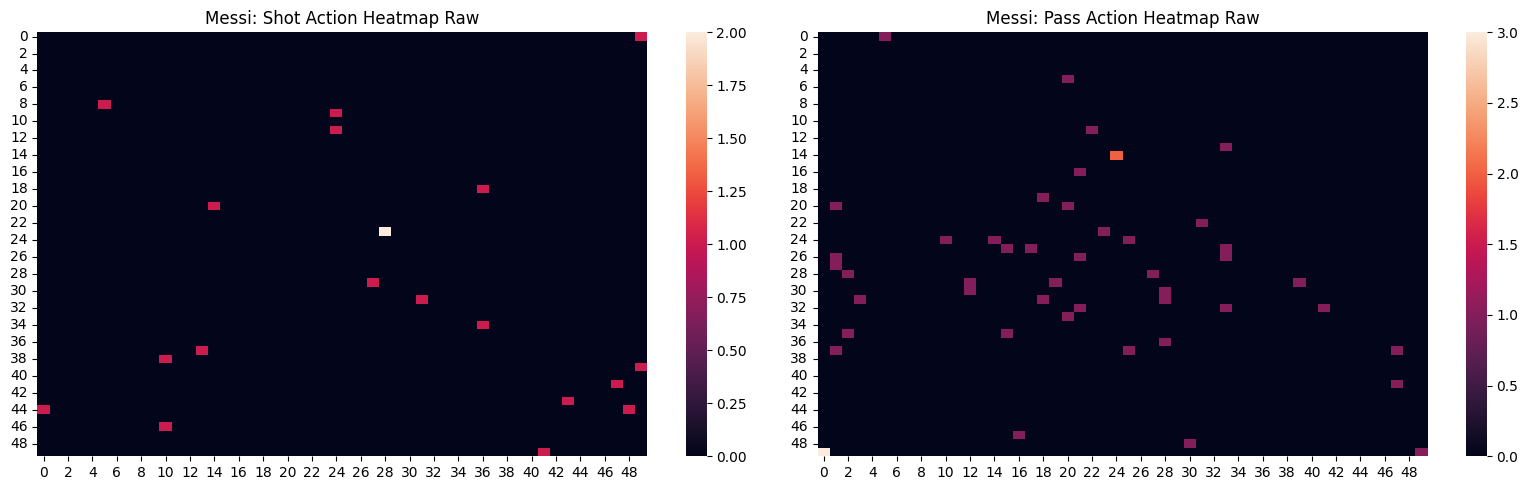

In [301]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(X_shot, ax=axs[0])
axs[0].set_title('Messi: Shot Action Heatmap Raw')
sns.heatmap(X_pass, ax=axs[1])
axs[1].set_title('Messi: Pass Action Heatmap Raw')
plt.tight_layout()
plt.show()

#### 1.2 Normalization: Skip this part for now

#### 1.3 Smoothing

In [302]:
# Apply gaussian filter
X_shot, X_pass = gaussian_filter(X_shot, sigma=sigma), gaussian_filter(X_pass, sigma=sigma)

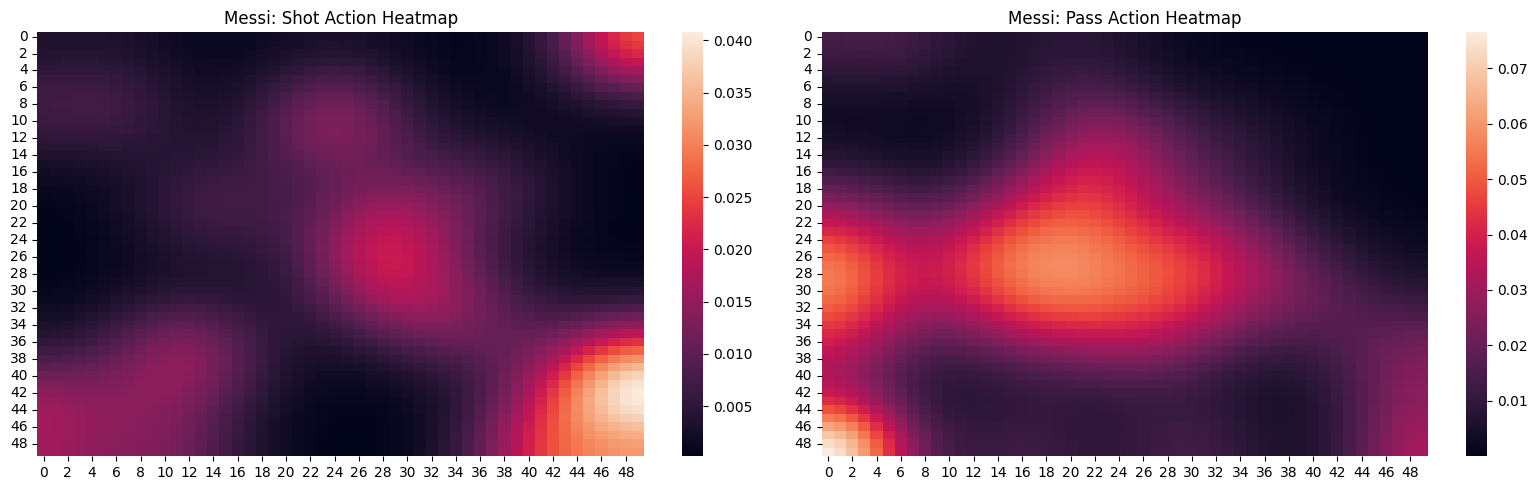

In [303]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(X_shot, ax=axs[0])
axs[0].set_title('Messi: Shot Action Heatmap')
sns.heatmap(X_pass, ax=axs[1])
axs[1].set_title('Messi: Pass Action Heatmap')
plt.tight_layout()
plt.show()

### 2. Compressing Heatmaps to Vectors

#### 2.1 Reshaping

In [304]:
X_reshape_shot = X_shot.reshape(X_shot.shape[0] * X_shot.shape[1]).reshape(-1, 1)
X_reshape_pass = X_pass.reshape(X_pass.shape[0] * X_pass.shape[1]).reshape(-1, 1)
print(f'Reshaped shot matrix: {X_reshape_shot.shape}')
print(f'Reshaped pass matrix: {X_reshape_pass.shape}')

Reshaped shot matrix: (2500, 1)
Reshaped pass matrix: (2500, 1)


#### NMF

In [305]:
model_shot = NMF(n_components=k, init='random', random_state=0)
model_pass = NMF(n_components=k, init='random', random_state=0)

In [306]:
W_shot = model_shot.fit_transform(X_reshape_shot)
H_shot = model_shot.components_

W_pass = model_pass.fit_transform(X_reshape_pass)
H_pass = model_pass.components_

In [307]:
print(f'Shape of W_shot: {W_shot.shape}')
print(f'Shape of H_shot: {H_shot.shape}')
print()
print(f'Shape of W_pass: {W_pass.shape}')
print(f'Shape of H_pass: {H_pass.shape}')

Shape of W_shot: (2500, 3)
Shape of H_shot: (3, 1)

Shape of W_pass: (2500, 3)
Shape of H_pass: (3, 1)


In [308]:
print(H_shot)

[[0.09109527]
 [0.02066403]
 [0.05054181]]


In [309]:
print(H_pass)

[[0.14258665]
 [0.03234432]
 [0.07911045]]


In [310]:
x, y = df_passes['x'], df_passes['y']

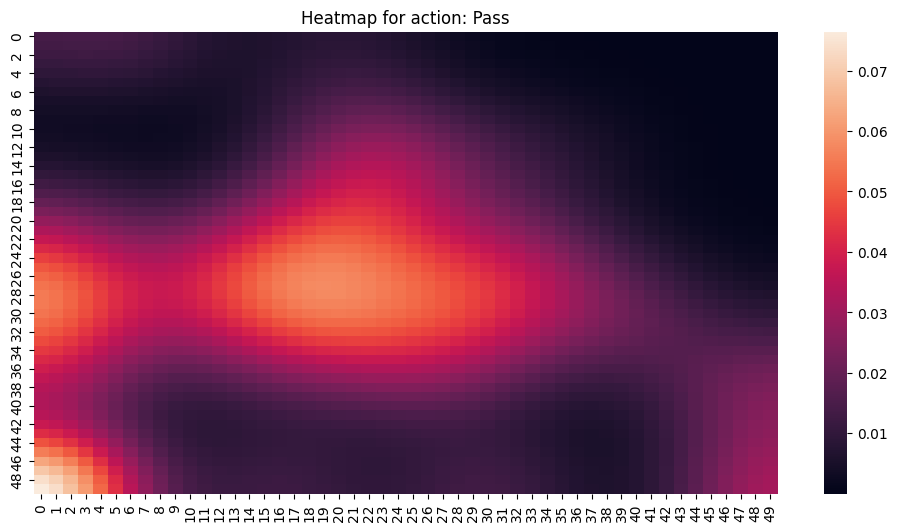

In [311]:
from playervectors import PlayerHeatMap

passes_player = PlayerHeatMap(sigma=5.0, acion_name='Pass')
passes_player.fit(x, y)

plt.figure(figsize=(12, 6))
passes_player.heatmap()
plt.show()

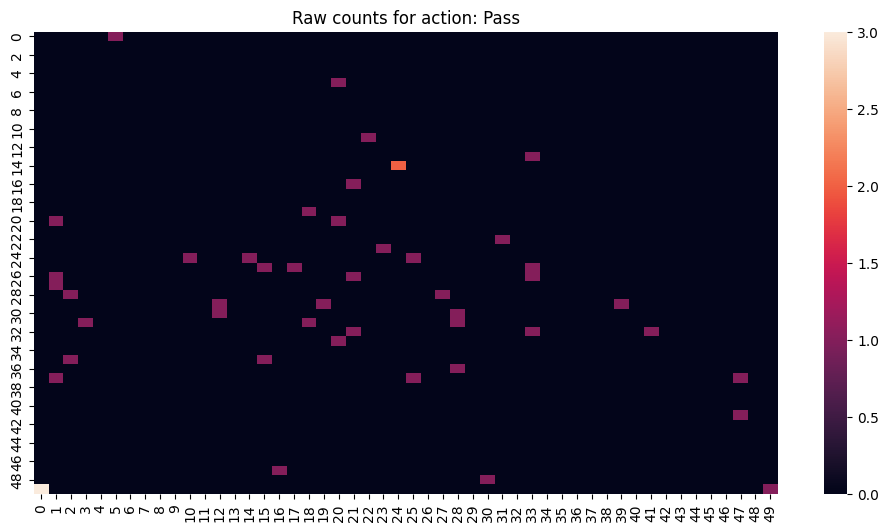

In [312]:

plt.figure(figsize=(12, 6))
passes_player.raw_counts()
plt.show()
